In [4]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Users\tiwar\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [5]:
!python -m ipykernel install --user --name torch-gpu-env --display-name "Python (GPU)"


Installed kernelspec torch-gpu-env in C:\Users\tiwar\AppData\Roaming\jupyter\kernels\torch-gpu-env


0.02s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


In [6]:
import sys
print(sys.executable)


C:\Users\tiwar\AppData\Local\Programs\Python\Python312\python.exe


In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np


In [8]:

print("PyTorch version:", torch.__version__)
print("GPU Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


PyTorch version: 2.5.1+cu121
GPU Available: True
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("amerzishminha/forest-fire-smoke-and-non-fire-image-dataset")

print("Path to dataset files:", path)

C:\Users\tiwar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\tiwar\.cache\kagglehub\datasets\amerzishminha\forest-fire-smoke-and-non-fire-image-dataset\versions\3


In [10]:
import kagglehub
import os

# Download dataset and get the correct path for your system
path = kagglehub.dataset_download("amerzishminha/forest-fire-smoke-and-non-fire-image-dataset")
print("Path to dataset files:", path)

# Build paths to train and test directories
train_dir = os.path.join(path, "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET", "train")
test_dir = os.path.join(path, "FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET", "test")

# Check folder contents
print("Train subfolders:", os.listdir(train_dir))
print("Test subfolders:", os.listdir(test_dir))


Path to dataset files: C:\Users\tiwar\.cache\kagglehub\datasets\amerzishminha\forest-fire-smoke-and-non-fire-image-dataset\versions\3
Train subfolders: ['fire', 'non fire', 'Smoke']
Test subfolders: ['fire', 'non fire', 'Smoke']


In [12]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader
import numpy as np

# Fix random seed (optional: ensures same subset each run)
np.random.seed(42)

# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# -------------------------
# Subset for training
train_subset_size = 5000   # adjust as needed
train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
train_subset = Subset(train_dataset, train_indices)

# Subset for testing (optional)
test_subset_size = 2000   # adjust as needed
test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)
test_subset = Subset(test_dataset, test_indices)
# -------------------------

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

# Check
print("Classes:", train_dataset.classes)
print("Train subset size:", len(train_subset))
print("Test subset size:", len(test_subset))


Classes: ['Smoke', 'fire', 'non fire']
Train subset size: 5000
Test subset size: 2000


In [34]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Get number of classes from the original dataset
# If you're using a Subset, access the underlying dataset
num_classes = len(train_loader.dataset.dataset.classes)

# Load ResNet18 (with pretrained weights for faster convergence)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 3  # start small to test, later increase
for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Acc: {train_acc:.2f}%")


Using device: cuda
Epoch [1/3] Loss: 0.2533 Acc: 91.82%
Epoch [2/3] Loss: 0.1808 Acc: 94.36%
Epoch [3/3] Loss: 0.1233 Acc: 96.24%


In [35]:
# Define a local directory to save the model
save_dir = "C:/Users/tiwar/Documents/ml_ops_project_version1"
os.makedirs(save_dir, exist_ok=True)

# Save path
save_path = os.path.join(save_dir, "fire_smoke_model.pth")
torch.save(model.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: C:/Users/tiwar/Documents/ml_ops_project_version1\fire_smoke_model.pth


In [36]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/ml_ops_project_version1/fire_smoke_model.pth"))
model.load_state_dict(torch.load("C:/Users/tiwar/Documents/ml_ops_project_version1/fire_smoke_model.pth"))


C:\Users\tiwar\AppData\Local\Temp\ipykernel_23388\4005412014.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("C:/Users/tiwar/Documents/m

<All keys matched successfully>

In [37]:
import torch
import torch.nn as nn
from torchvision import models

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Classes (must match training order) -----
# If you don't have train_dataset loaded yet, hardcode them:
classes = ['Smoke', 'fire', 'non fire']
num_classes = len(classes)

# ----- Recreate the same ResNet18 architecture -----
# If you trained from scratch in Colab, keep weights=None
# If you trained with pretrained ImageNet weights, change to:
# model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ----- Load trained weights -----
model_path = r"C:\Users\tiwar\Documents\ml_ops_project_version1\fire_smoke_model.pth"

try:
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    print(f" Model weights loaded from: {model_path}")
except FileNotFoundError:
    raise FileNotFoundError(f" Model file not found at: {model_path}")
except RuntimeError as e:
    raise RuntimeError(f" Error loading model: {e}")

# ----- Move to device & set to eval mode -----
model = model.to(device)
model.eval()

print(" Model ready for inference")


Using device: cuda


C:\Users\tiwar\AppData\Local\Temp\ipykernel_23388\2752118577.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


 Model weights loaded from: C:\Users\tiwar\Documents\ml_ops_project_version1\fire_smoke_model.pth
 Model ready for inference


 Test Subset Accuracy: 93.50%


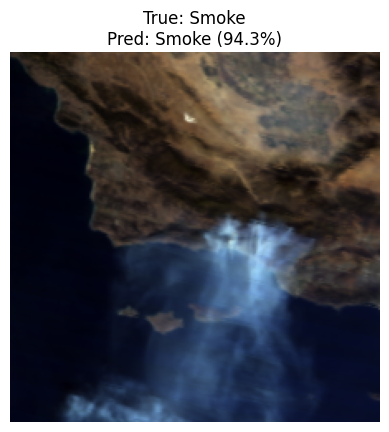

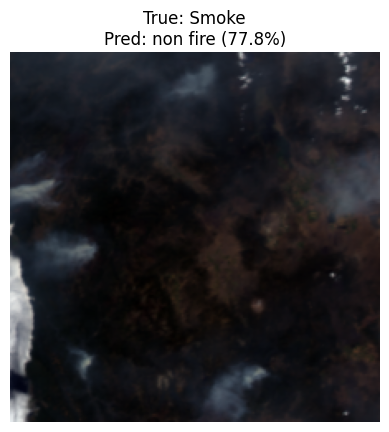

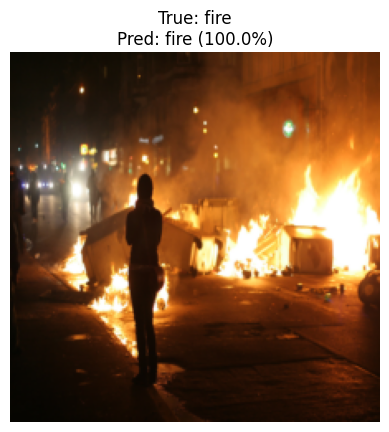

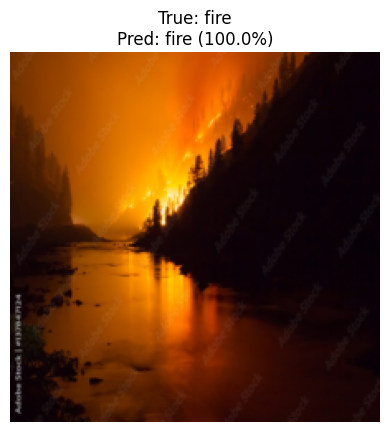

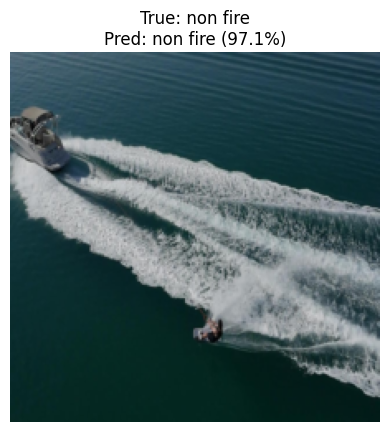

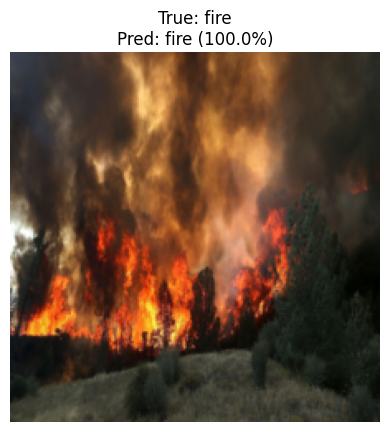

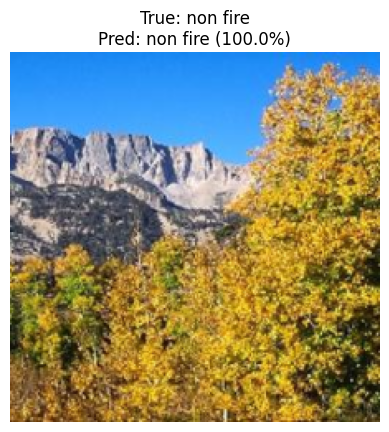

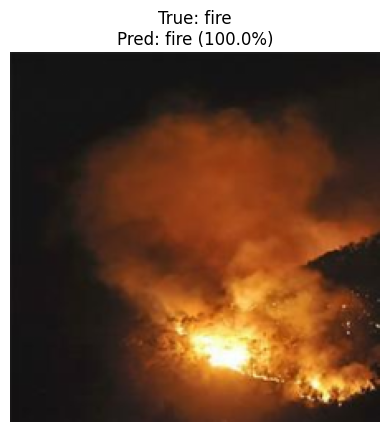

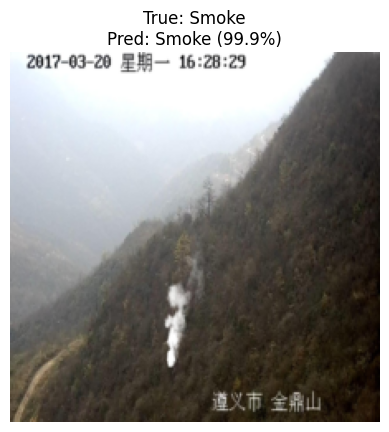

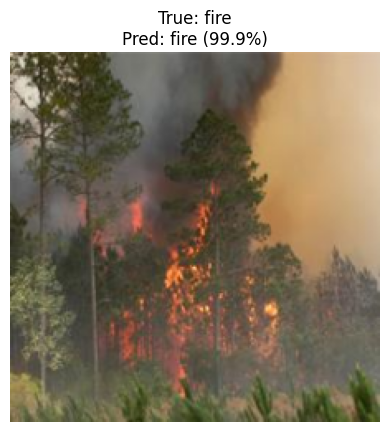

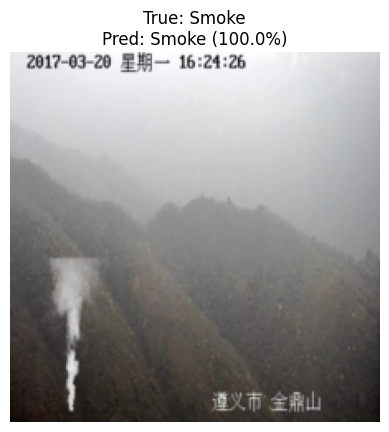

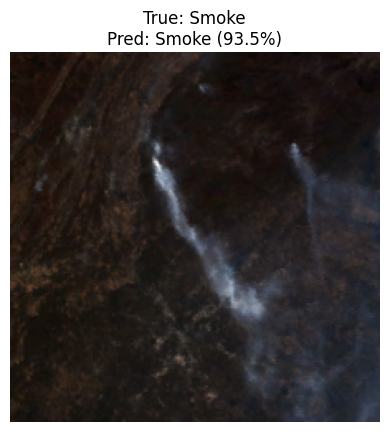

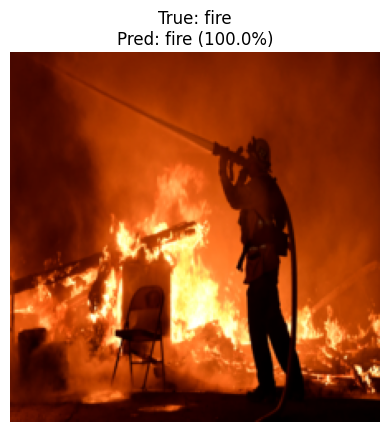

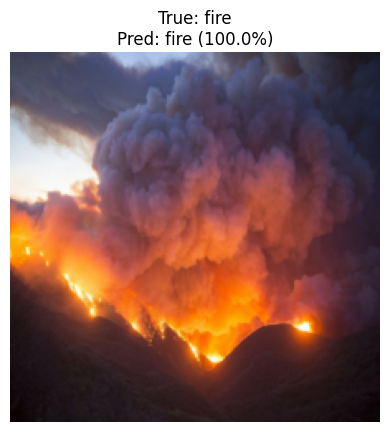

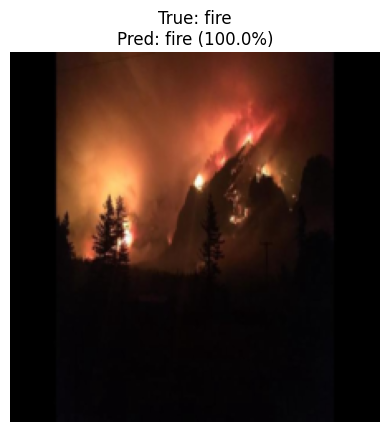

In [38]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to display images
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Evaluate on the test subset
model.eval()
correct, total = 0, 0

all_images, all_labels, all_preds, all_probs = [], [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # Save first batch for visualization
        if len(all_images) == 0:
            all_images = images
            all_labels = labels
            all_preds = preds
            all_probs = probs

accuracy = 100 * correct / total
print(f" Test Subset Accuracy: {accuracy:.2f}%")

# Show up to 15 images from the batch with predictions
classes = train_dataset.classes
for i in range(min(15, len(all_images))):
    img = all_images[i].cpu()
    true_label = classes[all_labels[i].item()]
    pred_label = classes[all_preds[i].item()]
    confidence = all_probs[i][all_preds[i]].item() * 100
    imshow(img, f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)")


In [39]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_custom_image(image_path, model, classes, device):
    """
    Predict a single image using the loaded model and show class probabilities.

    Args:
        image_path (str): Path to the image.
        model (torch.nn.Module): Loaded model.
        classes (list): List of class names.
        device (torch.device): Device (cuda or cpu).
    """

    # Check if file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # 1️ Load and transform the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # 2️ Predict
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    # 3️ Show image with prediction
    plt.imshow(np.array(image))
    plt.axis("off")
    plt.title(f"Predicted: {classes[pred_idx.item()]} ({conf.item()*100:.1f}%)")
    plt.show()

    # 4️ Print all class probabilities
    print("\nClass probabilities:")
    for i, c in enumerate(classes):
        print(f"{c}: {probs[0][i].item()*100:.2f}%")

    return classes[pred_idx.item()], conf.item(), probs.cpu().numpy()


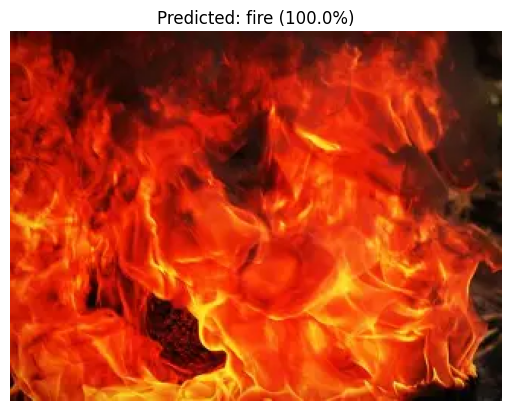


Class probabilities:
Smoke: 0.00%
fire: 100.00%
non fire: 0.00%


In [40]:
image_path = r"C:\Users\tiwar\Downloads\download.webp"

pred_label, confidence, all_probs = predict_custom_image(
    image_path, model, train_dataset.classes, device
)


In [32]:
!pip install gradio


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/60.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/60.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/60.4 MB ? eta -:--:--
   ---------------------------------------- 0.5/60.4 MB 2.1 MB/s eta 0:00:29
    --------------------------------------- 1.0/60.4 MB 1.7 MB/s eta 0:00:36
    --------------------------------------- 1.0/60.4 MB 1.7 MB/s eta 0:00:36
    --------------------------------------- 1.0/60.4 MB 1.7 MB/s eta 0:00:36
    --------------------------------------- 1.0/60.4 MB 1.7 MB/s eta 0:00:36
    --------------------------------------- 1.0/60.4 MB 1.7 MB/s eta 0:00:36
   - -------------------------------------- 1.6/60.4 MB 932.2 kB/s eta 0:01:04
   - -------------------------------------- 2.1/60.4 MB 1.0 MB/s eta 0:00:58
   - -------------------------------------- 2.1/60.4 MB 1.0 MB/s eta 0:00:58
   - ------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [43]:
import gradio as gr
from PIL import Image
import torch
from torchvision import transforms, models
import torch.nn as nn

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----- Classes (must match training order exactly) -----
classes = ['Smoke', 'fire', 'non fire']  # same order as during training
num_classes = len(classes)

# ----- Load Model -----
# Change weights=None to pretrained if you trained with pretrained backbone
# Example: weights=models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model_path = r"C:\Users\tiwar\Documents\ml_ops_project_version1\fire_smoke_model.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()
print(" Model loaded successfully")

# ----- Prediction Function -----
def predict(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    img = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, 1)

    label = classes[pred_idx.item()]
    confidence = round(conf.item() * 100, 2)  # for the text box
    probs_dict = {classes[i]: float(probs[0][i]) for i in range(len(classes))}  # raw 0–1
    
    return f"{label} ({confidence}%)", probs_dict


# ----- Gradio Interface -----
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Label(num_top_classes=num_classes, label="Class Probabilities")
    ],
    title="Forest Fire & Smoke Detection",
    description="Upload an image of a forest scene and the model will predict whether it is Fire, Smoke, or Non Fire."
)

# ----- Launch -----
iface.launch()


Using device: cuda


C:\Users\tiwar\AppData\Local\Temp\ipykernel_23388\2715754439.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

 Model loaded successfully
* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
